In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


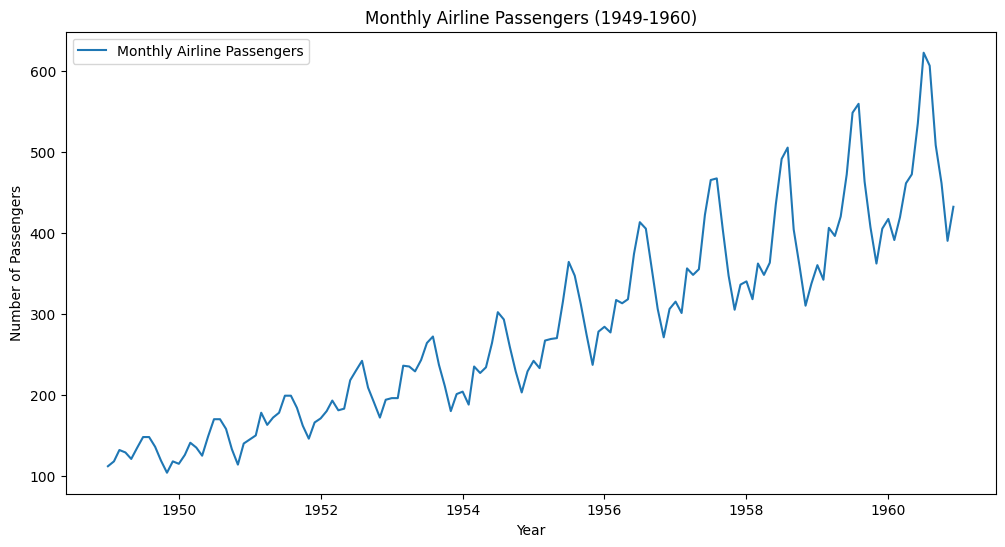

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Display the data
print(data.head())
plt.figure(figsize=(12, 6))
plt.plot(data, label='Monthly Airline Passengers')
plt.title("Monthly Airline Passengers (1949-1960)")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()


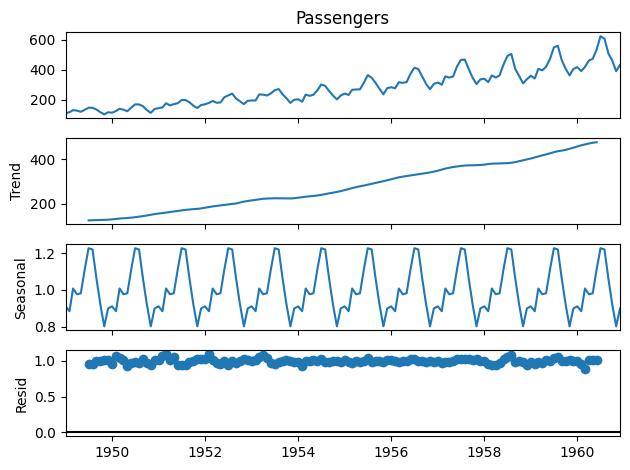

In [3]:
# Decomposing the time series
result = seasonal_decompose(data['Passengers'], model='multiplicative', period=12)

# Plot decomposition
result.plot()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -689.067
Date:                Fri, 06 Dec 2024   AIC                           1390.135
Time:                        23:30:46   BIC                           1407.912
Sample:                    01-01-1949   HQIC                          1397.358
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3223      0.097      3.334      0.001       0.133       0.512
ar.L2         -0.2170      0.078     -2.776      0.006      -0.370      -0.064
ar.L3         -0.0646      0.071     -0.915      0.3

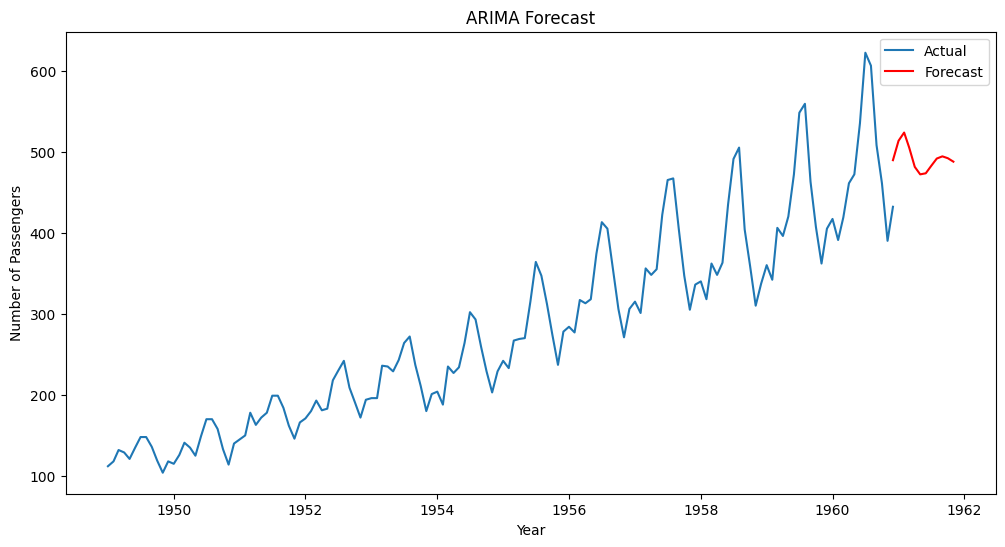

In [4]:
# Fit ARIMA model
model_arima = ARIMA(data['Passengers'], order=(5, 1, 0))
model_fit = model_arima.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
forecast = model_fit.forecast(steps=12)
print("Forecasted Values:\n", forecast)

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=12, freq='MS'), forecast, label='Forecast', color='red')
plt.title("ARIMA Forecast")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()


In [5]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values)

# Prepare training data
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_dataset(data_scaled, time_step)

# Reshape input to be [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.1012
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0393
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0117
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0181
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0120
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0104
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0146
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0087
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0083
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0095
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0081
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0089
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0075
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0069
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0102
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


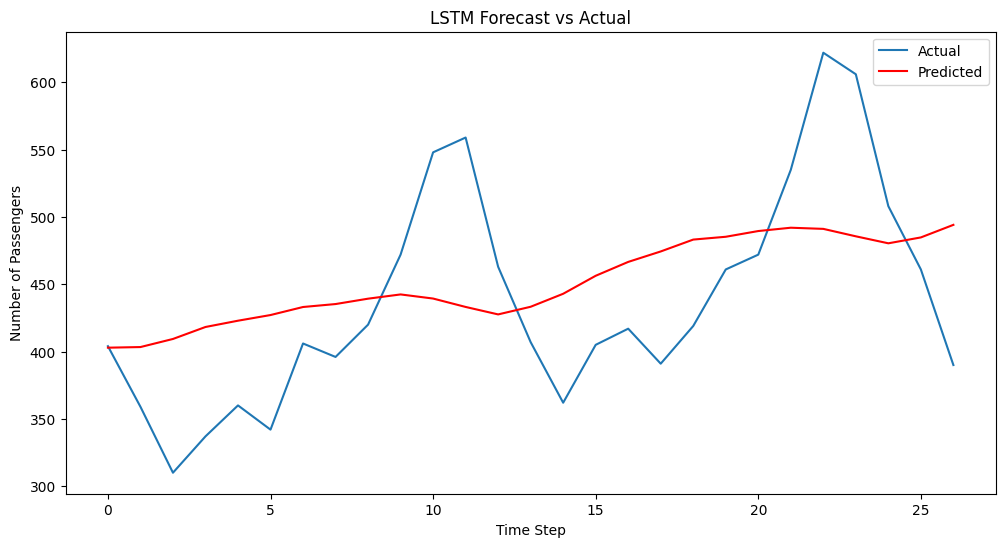

LSTM Model RMSE: 69.92


In [6]:
# Predict and inverse scale
y_pred = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='red')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"LSTM Model RMSE: {rmse:.2f}")
